# The finite volume method for unsteady flow

The conservation law for the transport of a scalar in an unsteady flow has the general form

$$
\frac{\partial}{\partial {t}} (\rho \phi) + div (\rho \textbf{u} \phi) 
= div (\Gamma\ grad \ \phi) + S_{\phi}
$$

## 1D unsteady state heat conduction

$$
\rho c \frac{\partial{T}}{\partial{t}} = \frac{\partial}{\partial{x}} (k\frac{\partial{T}}{\partial{x}}) + S
$$


**Question**

A thin plate is initially at a uniform temperature of 200°C. At a certain time
t = 0 the temperature of the east side of the plate is suddenly reduced to 0°C.
The other surface is insulated. Use the explicit finite volume method in conjunction with a suitable time step size to calculate the transient temperature
distribution of the slab and compare it with the analytical solution at time 
(i) t = 40 s, (ii) t = 80 s and (iii) t = 120 s. Recalculate the numerical solution
using a time step size equal to the limit given by for t = 40 s and compare the results with the analytical solution. The data are: plate thickness 
L = 2 cm, thermal conductivity k = 10 W/m.K and ρc = 10 × 10^6 J/m3.K. 

// TODO: Add reference later

The 1D transient heat conduction equation is 


$$
\rho c \frac{\partial{T}}{\partial{t}} = \frac{\partial}{\partial{x}} (k\frac{\partial{T}}{\partial{x}})
$$

and the initial conditions are 

$$
T = 200\ at\ t = 0
$$
and the boundary conditions are
$$
\frac{\partial{T}}{\partial{x}} = 0\ at\ x=0,\ t>0
\\ T = 0\ at\ x = L,\ t>0
$$

In [ ]:
import numpy as np

np.abs

In [67]:
from math import cos, exp, pi, inf

def analytical_sol(x: float, t: float, alpha: float, 
                   L: float, T_init: float,tol=1e-6, max_iter=1000):
    '''
    An implementation of the analytical solution given by Ozisik (1985).

    Parameters:
        x (float): position in rod
        t (float): time
        alpha (float): thermal diffusivity = k/pc
        L (float): length of rod
        T_init (float): initial temperature of rod
        tol (float): calculation tolerance
        max_iter (int): Maximum number of iterations

    Returns:
        temperature (float): Temperature of rod at position 'x' and time 't'
    '''

    calc_tol = inf
    sum_n_1 = 0
    sum_n = 0
    n = 1

    while (tol < calc_tol):
        lambda_n = (2*n - 1)* pi/(2 * L)
        sum_n += (((-1)**(n + 1))/(2*n - 1)) * exp(-alpha * lambda_n**2 * t) * cos(lambda_n * x)

        calc_tol = abs(sum_n - sum_n_1)
        sum_n_1 = sum_n

        if (n > max_iter): return f"Failed to converge in {max_iter} iterations"
        
        n+=1
    
    return sum_n * (4/pi) * T_init



In [68]:
# Analytical solution
result = analytical_sol(0.01, 40, (10/(10*1e6)), 0.02, 200)


In [199]:
# Explicit solution
import numpy as np

k = 10
rho = 10
c = 1e6
L = 0.02
time_span =25
dt = 0.5

n_nodes = 20
dx = L/n_nodes

# Initial condition
T_init = np.ones(n_nodes) * 200

# Boundary conditions
T_B = 0 # East side temperature fixed at 0

T = np.copy(T_init)

# Condition for convergence
dt_critical = rho * c * dt**2 / (2 * k)

if (dt > dt_critical): raise ValueError('Time delta is greater than critical time delta')

t = 0

# Temperature profile 
n_time_steps = int(time_span/dt)
T_profile = np.zeros((n_time_steps + 2, len(T)))

T_profile[0] = T

i = 1
while(t <= time_span):
    t += dt
    
    k_dx = k/dx
    a_W, a_E = k_dx, k_dx
    a_P = rho * c * dx/dt

    # Internal nodes 
    T[1:-1] = (a_W * T[0:-2] + a_E * T[2:] + (a_P - (a_W + a_E)) * T[1:-1]) / a_P

    # Boundary nodes
    T[0] = (a_E * T[1] + (a_P - a_E) * T[0])/a_P
    T[-1] = (a_W * T[-2] + (a_P - a_W) * T[-1] + 2 * k_dx * (T_B - T[-1]))/a_P

    T_profile[i] = T
    i += 1

In [200]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from functools import partial


def plot_T_profile(node_points: NDArray[np.float64], 
                   T_profile: NDArray[np.float64], save_mp4=False):
        
    fig, ax = plt.subplots()

    line, = ax.plot(node_points, T_profile[0])

    def init():
        ax.set_xlim(0, 0.02)
        return line,

    def update(frame, line):
        y = T_profile[frame]
        line.set_data(node_points,T_profile[frame])
        return line,


    ani = FuncAnimation(fig, func=partial(update, line=line), 
                        frames=len(T_profile), init_func=init, blit=True)

    if save_mp4:
        writer = FFMpegWriter()
        ani.save('1d_heat_equation.mp4', writer=writer)

    plt.show()


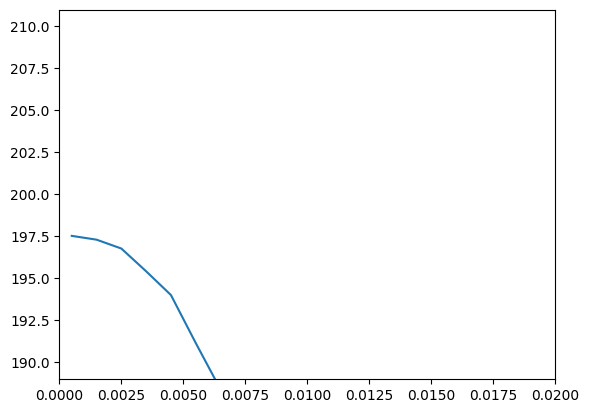

In [201]:
L = 0.02
n_nodes = 20
leftmost_node = dx/2
rightmost_node = L - dx/2

node_points = np.linspace(leftmost_node, rightmost_node, n_nodes)
plot_T_profile(node_points, T_profile, save_mp4=True)